In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
import random

In [2]:
#Read file related to testing
def get_test_file():
    '''Generator that return string of file name'''
    import re
    for files in os.listdir():
        if re.match('test.+\.csv', files) is not None:
            yield files
            
def csv_to_np(filename):
    return pd.read_csv(filename, header=None, delim_whitespace=True).values
    

In [3]:
bandwidth_matrix = csv_to_np('test1.csv')
num_of_nodes = bandwidth_matrix.shape[0]
print(num_of_nodes, '\n', bandwidth_matrix)

20 
 [[ 0  0  0  0  0  0  0  0  0 13  0  9 13  0  0  0 12  3  3  0]
 [ 0  0  8 13  9  0  0  0  0  0  3  2  0  0  4 13  9  6  8  2]
 [ 0  8  0  0  7  9  0  0  0  0  1  0  9 13  0  0 10  1  0  0]
 [ 0 13  0  0  0 15 13 16 10  0  0  0  1  0  0 12  0  6  0  0]
 [ 0  9  7  0  0  0  3  0 12  0  0  0  0  0 16  9  0  2  2  0]
 [ 0  0  9 15  0  0  8 14  0  0  0 15  0  9  2  3  5  0  0  7]
 [ 0  0  0 13  3  8  0 10 13 11  0  7 14  2  0  0  0 11  0  3]
 [ 0  0  0 16  0 14 10  0  0  9  0  6  0 12  6  5 15  0  0  0]
 [ 0  0  0 10 12  0 13  0  0  4  6  0  6  5  0  0 11  0  9  0]
 [13  0  0  0  0  0 11  9  4  0  0 11  0  0  2  2  0  8  1 13]
 [ 0  3  1  0  0  0  0  0  6  0  0  0  0  1 10 12  0  0  0  0]
 [ 9  2  0  0  0 15  7  6  0 11  0  0 11  1  7  0  5  0  0  0]
 [13  0  9  1  0  0 14  0  6  0  0 11  0  3  0 14  0  0  0  6]
 [ 0  0 13  0  0  9  2 12  5  1  1  1  3  0  0  0  0  0 12 10]
 [ 0  4  0  0 16  2  0  6  0  2 10  7  0  0  0  5  1  0  7  0]
 [ 0 13  0 12  9  3  0  5  0  2 12  0 14  0  5  0 

In [4]:
# build neighbor matrix
neighbor_matrix = []
for row, _ in enumerate(bandwidth_matrix):
    neighbor_matrix.append(np.where(bandwidth_matrix[row] > 0)[0])
    
neighbor_matrix = np.array(neighbor_matrix)

In [5]:
# build the list of edges
edges = np.array(np.where(bandwidth_matrix > 0)).transpose()+1

# build nx Graph instance
G = nx.Graph()
G.add_nodes_from(range(1, num_of_nodes+1))
G.add_edges_from(edges)

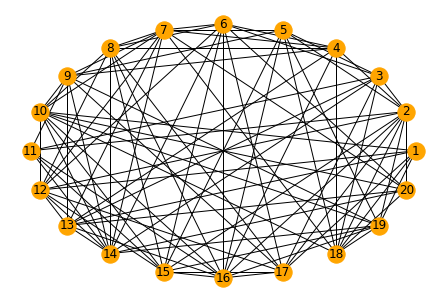

In [9]:
# Visualize the graph
%matplotlib inline
nx.draw_shell(G, with_labels=True, node_color='orange')

In [7]:
def initial(G, s, d, iddfs_depth, population_size):

    # Add shortest paths (seeding)
    shortest_path_generator = nx.all_shortest_paths(G, source=s, target=d)
    shortest_paths = list(shortest_path_generator)
    
    # Add worse path
    path_generator = nx.all_simple_paths(G, source=1, target=4, cutoff=iddfs_depth)
    paths = list(path_generator)

    long_paths = random.sample(paths, population_size - len(shortest_paths))
    
    return shortest_paths+long_paths

In [10]:
pop = initial(G, 1, 4, 7, 20)
pop

# Edge density of graph
G.size()*2/G.order()*(G.order()-1)

[[1, 13, 4],
 [1, 18, 4],
 [1, 12, 17, 3, 14, 11, 16, 4],
 [1, 13, 14, 10, 8, 12, 7, 4],
 [1, 19, 10, 16, 15, 2, 18, 4],
 [1, 10, 18, 19, 16, 11, 9, 4],
 [1, 17, 12, 7, 9, 10, 18, 4],
 [1, 12, 6, 20, 14, 8, 16, 4],
 [1, 17, 3, 6, 8, 12, 13, 4],
 [1, 18, 20, 10, 15, 11, 9, 4],
 [1, 12, 10, 20, 2, 5, 18, 4],
 [1, 19, 16, 8, 10, 7, 6, 4],
 [1, 13, 16, 17, 3, 5, 9, 4],
 [1, 12, 15, 11, 9, 7, 6, 4],
 [1, 18, 19, 10, 9, 13, 7, 4],
 [1, 12, 8, 6, 20, 13, 16, 4],
 [1, 10, 7, 12, 13, 16, 4],
 [1, 13, 7, 14, 9, 17, 6, 4],
 [1, 12, 8, 6, 3, 2, 16, 4],
 [1, 18, 10, 19, 14, 12, 8, 4]]